In [2]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# --- 1. SETTINGS ---
TARGET_CLASSES = [
    "Apple", "Banana", "Orange", "Mango", "Grapes",
    "Pineapple", "Watermelon", "Pomegranate", "Strawberry", "Lemon"
]

In [3]:
# --- 2. LOAD AND PREPARE DATASET ---
print("Loading Dataset from Hugging Face...")
dataset = load_dataset("ysif9/fruit-recognition")

# Filter Classes
all_class_names = dataset['train'].features['label'].names
target_ids = [all_class_names.index(name) for name in TARGET_CLASSES if name in all_class_names]
dataset = dataset.filter(lambda example: example['label'] in target_ids)

# Remap labels to 0-9 range
label_mapping = {old_id: new_id for new_id, old_id in enumerate(target_ids)}
def remap_labels(example):
    example['label'] = label_mapping[example['label']]
    return example

dataset = dataset.map(remap_labels)

print(f"Dataset loaded with {len(dataset['train'])} training samples")
print(f"Classes: {TARGET_CLASSES}")

Loading Dataset from Hugging Face...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00005.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

data/train-00001-of-00005.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

data/train-00002-of-00005.parquet:   0%|          | 0.00/378M [00:00<?, ?B/s]

data/train-00003-of-00005.parquet:   0%|          | 0.00/436M [00:00<?, ?B/s]

data/train-00004-of-00005.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/261M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25659 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6821 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7070 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25659 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6821 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7070 [00:00<?, ? examples/s]

Map:   0%|          | 0/17203 [00:00<?, ? examples/s]

Map:   0%|          | 0/4006 [00:00<?, ? examples/s]

Map:   0%|          | 0/5077 [00:00<?, ? examples/s]

Dataset loaded with 17203 training samples
Classes: ['Apple', 'Banana', 'Orange', 'Mango', 'Grapes', 'Pineapple', 'Watermelon', 'Pomegranate', 'Strawberry', 'Lemon']


In [4]:
IMG_SIZE = 224

NUM_CLASSES = len(TARGET_CLASSES)

def process_split_efficiently(hf_split):
    print(f"Processing {len(hf_split)} images...")

    # 1. Pre-allocate the array
    num_samples = len(hf_split)
    X_data = np.empty((num_samples, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
    y_labels = []


    for i, example in enumerate(hf_split):
        img = example['image'].convert('RGB').resize((IMG_SIZE, IMG_SIZE))
        X_data[i] = np.array(img, dtype=np.uint8) # Direct insert
        y_labels.append(example['label'])


        if i % 1000 == 0:
            print(f"Processed {i}/{num_samples}")


    Y_data = to_categorical(y_labels, num_classes=NUM_CLASSES)

    return X_data, Y_data

In [6]:
import os
import numpy as np
from google.colab import drive
from tensorflow.keras.utils import to_categorical
from PIL import Image

# 1. SETUP PATHS
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/Fruit_Recognition_Data'

# Create folder if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


files_exist = (
    os.path.exists(f'{save_dir}/X_train.npy') and
    os.path.exists(f'{save_dir}/y_train.npy') and
    os.path.exists(f'{save_dir}/X_val.npy') and
    os.path.exists(f'{save_dir}/y_val.npy')
)


if files_exist:
    print("-" * 40)
    print(" Found pre-processed data in Google Drive!")
    print("Loading directly from disk...")

    # MEMORY HACK: mmap_mode='r'


    X_train = np.load(f'{save_dir}/X_train.npy', mmap_mode='r')
    y_train = np.load(f'{save_dir}/y_train.npy')
    X_val = np.load(f'{save_dir}/X_val.npy', mmap_mode='r')
    y_val = np.load(f'{save_dir}/y_val.npy')

    print("Loaded successfully with Memory Mapping (RAM saved).")

else:
    print("-" * 40)
    print(" Processed files not found. Processing now...")

    # Convert
    print("Converting Training Data...")
    X_train, y_train = process_split_efficiently(dataset['train'])

    print("Converting Validation Data...")
    X_val, y_val = process_split_efficiently(dataset['validation'])

    # --- SAVE TO DRIVE ---
    print(f"Saving arrays to {save_dir}...")
    np.save(f'{save_dir}/X_train.npy', X_train)
    np.save(f'{save_dir}/y_train.npy', y_train)
    np.save(f'{save_dir}/X_val.npy', X_val)
    np.save(f'{save_dir}/y_val.npy', y_val)
    print("Saved!")

# 4. FINAL CHECK
print("-" * 40)
print(f"Data Ready for Training!")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
----------------------------------------
 Processed files not found. Processing now...
Converting Training Data...
Processing 17203 images...
Processed 0/17203
Processed 1000/17203
Processed 2000/17203
Processed 3000/17203
Processed 4000/17203
Processed 5000/17203
Processed 6000/17203
Processed 7000/17203
Processed 8000/17203
Processed 9000/17203
Processed 10000/17203
Processed 11000/17203
Processed 12000/17203
Processed 13000/17203
Processed 14000/17203
Processed 15000/17203
Processed 16000/17203
Processed 17000/17203
Converting Validation Data...
Processing 4006 images...
Processed 0/4006
Processed 1000/4006
Processed 2000/4006
Processed 3000/4006
Processed 4000/4006
Saving arrays to /content/drive/MyDrive/Fruit_Recognition_Data...
Saved!
----------------------------------------
Data Ready for Training!
X_train shape: (17203, 224, 224, 3)
y_train shape: (17

In [7]:
# Re-download base model with new input shape
MobileNetV2_base = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'
)
MobileNetV2_base.trainable = False

model = Sequential([
    # We add a Rescaling layer here so the GPU handles the /255.0 math
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),

    #  Add Data Augmentation
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),

    MobileNetV2_base,
    BatchNormalization(),
    Dropout(0.35),
    Dense(220, activation='relu'),
    Dense(60, activation='relu'),
    Dense(len(TARGET_CLASSES), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# --- 7. TRAIN MODEL ---
print("\nTraining model...")

# Define early stopping callback
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,  # Increased batch size since images are smaller
    epochs=100,
    callbacks=[early_stopping]
)


Training model...
Epoch 1/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 47s 130ms/step - accuracy: 0.7123 - loss: 0.8761 - val_accuracy: 0.8969 - val_loss: 0.3077
Epoch 2/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 32s 119ms/step - accuracy: 0.8660 - loss: 0.3908 - val_accuracy: 0.9106 - val_loss: 0.2804
Epoch 3/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 33s 122ms/step - accuracy: 0.8937 - loss: 0.3149 - val_accuracy: 0.9144 - val_loss: 0.2577
Epoch 4/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - accuracy: 0.8969 - loss: 0.2973 - val_accuracy: 0.9206 - val_loss: 0.2558
Epoch 5/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 33s 123ms/step - accuracy: 0.9091 - loss: 0.2671 - val_accuracy: 0.9214 - val_loss: 0.2450
Epoch 6/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 33s 123ms/step - accuracy: 0.9158 - loss: 0.2491 - val_accuracy: 0.9186 - val_loss: 0.2479
Epoch 7/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 33s 124ms/step - accuracy: 0.9178 - loss: 0.2296 - val_accuracy: 0.9161 - val_loss: 0.2702
Epoch 8/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 33s 123ms/step -

In [9]:
# --- 8. EVALUATE MODEL ---
print("\nEvaluating model...")
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


Evaluating model...
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9293 - loss: 0.2286
Validation Loss: 0.2270
Validation Accuracy: 0.9296


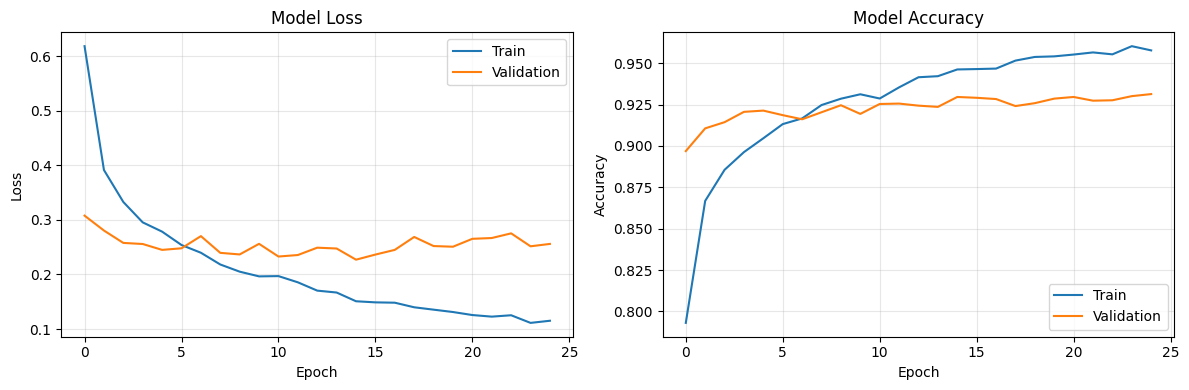

In [10]:
# --- 9. PLOT TRAINING HISTORY ---
# Plot loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# --- 10. SAVE MODEL (OPTIONAL) ---
# model.save('fruit_recognition_model.keras')
print("\nTraining complete!")


Training complete!


In [12]:
X_test, y_test = process_split_efficiently(dataset['test'])

Processing 5077 images...
Processed 0/5077
Processed 1000/5077
Processed 2000/5077
Processed 3000/5077
Processed 4000/5077
Processed 5000/5077


In [13]:
import numpy as np
# --- TEST MODEL ---
print("\nEvaluating model...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Evaluating model...
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.8710 - loss: 0.4663
Test Loss: 0.3797
Test Accuracy: 0.8909



Generating Confusion Matrix...
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step


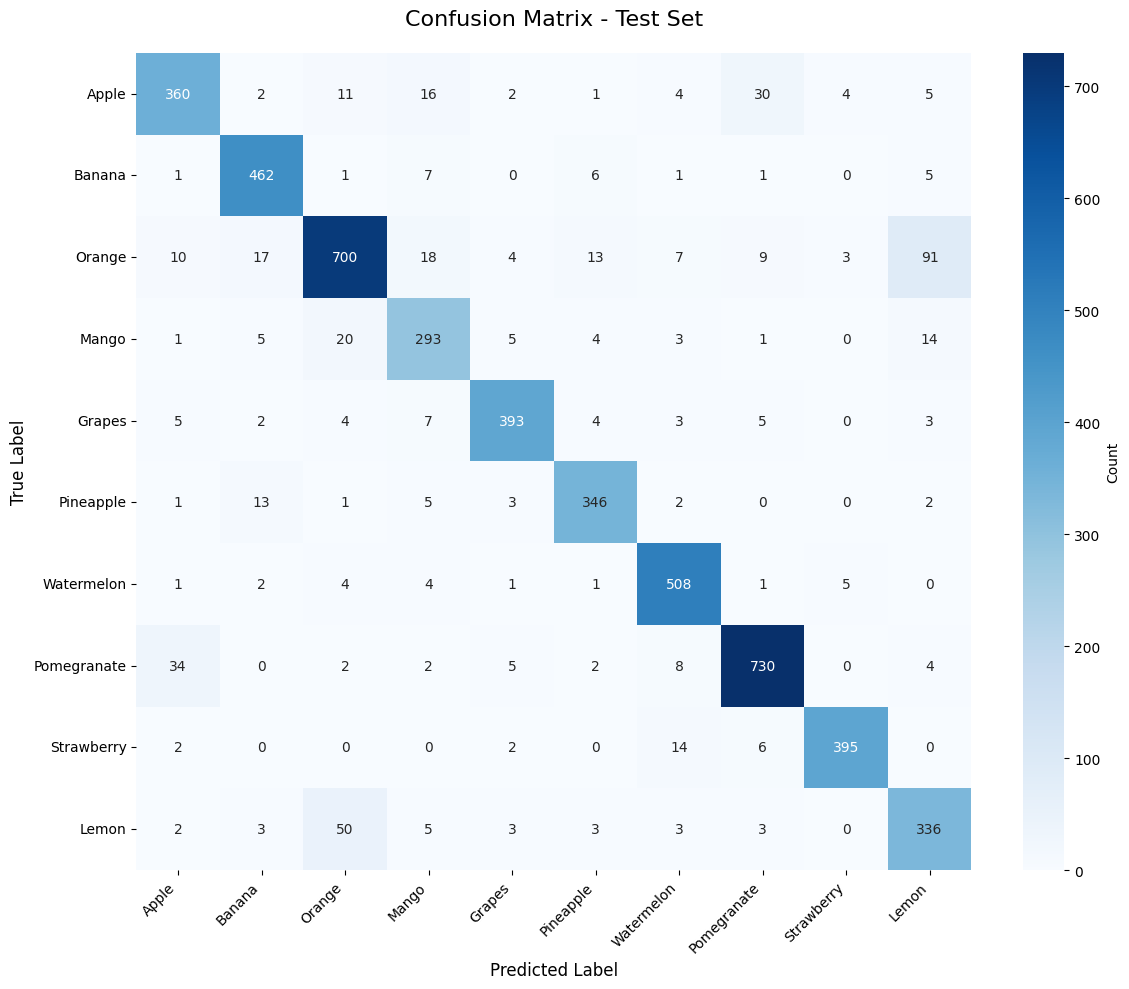


Classification Report:
              precision    recall  f1-score   support

       Apple       0.86      0.83      0.85       435
      Banana       0.91      0.95      0.93       484
      Orange       0.88      0.80      0.84       872
       Mango       0.82      0.85      0.83       346
      Grapes       0.94      0.92      0.93       426
   Pineapple       0.91      0.93      0.92       373
  Watermelon       0.92      0.96      0.94       527
 Pomegranate       0.93      0.93      0.93       787
  Strawberry       0.97      0.94      0.96       419
       Lemon       0.73      0.82      0.77       408

    accuracy                           0.89      5077
   macro avg       0.89      0.89      0.89      5077
weighted avg       0.89      0.89      0.89      5077



In [14]:
# --- CONFUSION MATRIX ---
from sklearn.metrics import confusion_matrix, classification_report

print("\nGenerating Confusion Matrix...")

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=TARGET_CLASSES,
            yticklabels=TARGET_CLASSES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=TARGET_CLASSES))